In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import seaborn as sns
import os
import sqlite3

# Preprocessing
#from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_validate
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler

# Model
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
import optuna
import shap
import joblib
import keras

from scripts.config import DATA_PATH, MODELS_PATH

%load_ext autoreload
%autoreload 2

%load_ext tensorboard

from tempfile import mkdtemp
# Create a temp folder
cachedir = mkdtemp()

2025-08-25 16:14:38.627726: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-25 16:14:38.628923: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-25 16:14:38.633686: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-25 16:14:38.642970: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756131278.658808   42750 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756131278.66

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/ronan/code/Power_Price_Forecasting/scripts/preprocess_att.py:709: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['Month'] = df['datetime'].dt.to_period('M')


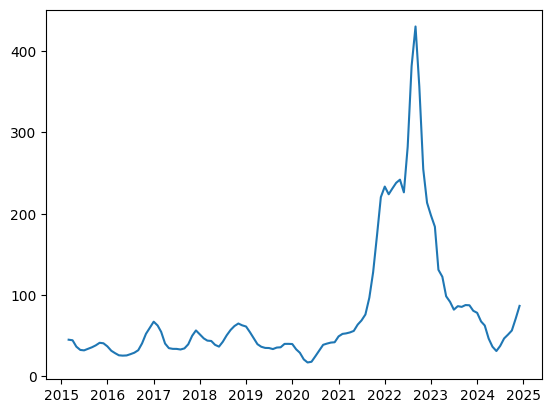

In [2]:
model_data = pd.read_csv(os.path.join(DATA_PATH, 'ATT', 'model_data.csv'))

from scripts.preprocess_att import monthly_statistics

monthly_stats = monthly_statistics(model_data)

plt.plot(monthly_stats.index, monthly_stats['3-Month Rolling Average'])

# 1. Import processed data

In [3]:
X_past_train_transformed = np.load(os.path.join(DATA_PATH, 'ATT', 'rolling_horizon', 'X_past_train_transformed_fold_5.npy'))
X_future_train_transformed = np.load(os.path.join(DATA_PATH, 'ATT', 'rolling_horizon', 'X_future_train_transformed_fold_5.npy'))
X_past_val_transformed = np.load(os.path.join(DATA_PATH, 'ATT', 'rolling_horizon', 'X_past_val_transformed_fold_5.npy'))
X_future_val_transformed = np.load(os.path.join(DATA_PATH, 'ATT', 'rolling_horizon', 'X_future_val_transformed_fold_5.npy'))


# 2. Forecast with simple LSTM

In [ ]:
from scripts.model_lstm import LSTMModel

lstm_model = LSTMModel(
    # LSTM parameters
    lstm_units=32,        # Good starting point: ~2-4x number of features
    dense_units=16,        # Half of LSTM units for dimensionality reduction

    # Input dimensions (from your data)
    n_past_features=X_past_train_transformed.shape[2],
    n_future_features=X_future_train_transformed.shape[2],
    past_seq_len=X_past_train_transformed.shape[1],
    future_seq_len=X_future_train_transformed.shape[1],

    # Regularization
    dropout=0.1,           # Moderate dropout to prevent overfitting
    batch_normalization=False,

    # Training parameters
    learning_rate=0.001,   # Standard learning rate for Adam
    verbose=True,
    epochs_early_stopping=20,

    # Loss and metrics
    loss='mse',
    metrics=['mae', 'mape'],

    # Additional regularization
    regularization='l2',
    lambda_reg=0.01       # Small L2 penalty
)

lstm_model

2025-08-25 16:14:42.293970: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Fitting fold 1 of 5
Training period: 2015-01-05 00:00:00+01:00 to 2016-04-14 23:00:00+02:00
Validation period: 2016-04-23 00:00:00+02:00 to 2016-08-12 23:00:00+02:00
Epoch 1/1000
1/9 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - loss: 1472.1819 - mae: 36.1054 - mape: 99.9682

2025-08-25 16:14:46.637101: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - loss: 1515.9146 - mae: 36.5443 - mape: 99.7394 - val_loss: 618.6213 - val_mae: 23.1671 - val_mape: 90.6298 - learning_rate: 0.0010
Epoch 2/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1522.7524 - mae: 36.6543 - mape: 100.0601 - val_loss: 546.7378 - val_mae: 21.7785 - val_mape: 84.5142 - learning_rate: 0.0010
Epoch 3/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1542.2756 - mae: 36.9012 - mape: 100.0290 - val_loss: 502.2582 - val_mae: 20.8373 - val_mape: 80.6526 - learning_rate: 0.0010
Epoch 4/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1418.1433 - mae: 35.3383 - mape: 100.1924 - val_loss: 476.0108 - val_mae: 20.2810 - val_mape: 78.3734 - learning_rate: 0.0010
Epoch 5/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1531.5626 - mae: 36.7244 - mape: 100.1786 - val_loss: 453.6493 - val_mae: 19.7939 - val_mape: 76.4096 - learning_rate: 0.0010
Epoch 6/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1561.8839 - mae: 37.1626 - ma

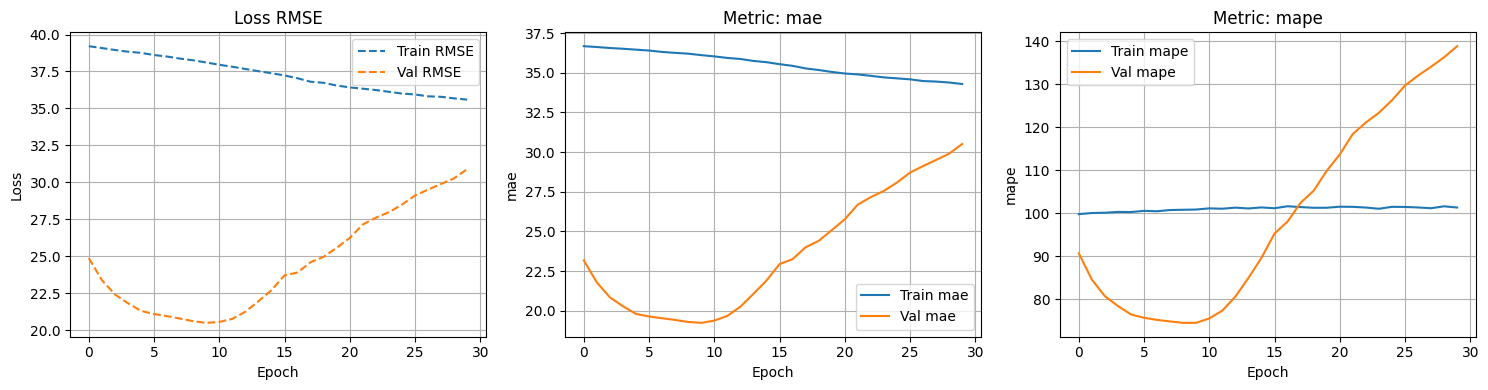

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 407.1838 - mae: 18.8657 - mape: 73.9929
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1143.4834 - mae: 31.8276 - mape: 77.4437

Final Training Metrics:
RMSE: 30.7215
['mae', 'mape']: [28.283174514770508, 75.37564086914062]

Final Validation Metrics:
RMSE: 20.4869
['mae', 'mape']: [19.22893524169922, 74.45791625976562]
Fitting fold 2 of 5
Training period: 2015-01-05 00:00:00+01:00 to 2017-08-02 23:00:00+02:00
Validation period: 2017-08-11 00:00:00+02:00 to 2018-02-27 23:00:00+01:00
Epoch 1/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1688.5966 - mae: 37.3832 - mape: 100.8674 - val_loss: 1547.8605 - val_mae: 35.6051 - val_mape: 84.8618 - learning_rate: 2.5000e-04
Epoch 2/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 1676.4598 - mae: 37.6245 - mape: 101.1049 - val_loss: 1586.4650 - val_mae: 36.2327 - val_mape: 84.4547 - learning_rate: 2.5000e-04
Epoch 3/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 1747.1929 - mae: 37.973

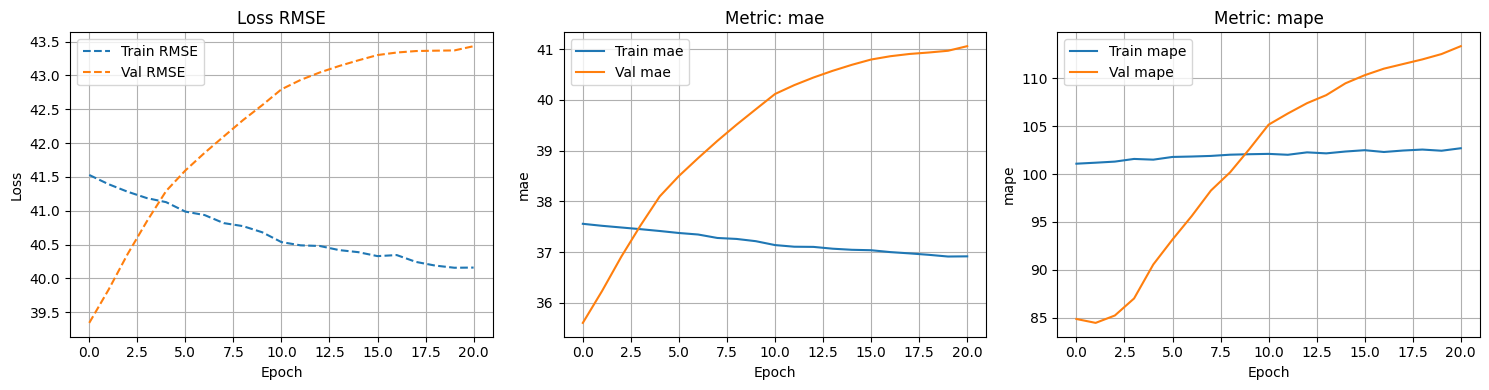

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1470.0516 - mae: 34.8502 - mape: 89.3746
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1198.2277 - mae: 31.5699 - mape: 80.1380

Final Training Metrics:
RMSE: 35.6300
['mae', 'mape']: [31.096460342407227, 80.1177749633789]

Final Validation Metrics:
RMSE: 39.3429
['mae', 'mape']: [35.605064392089844, 84.86180877685547]
Fitting fold 3 of 5
Training period: 2015-01-05 00:00:00+01:00 to 2018-08-08 23:00:00+02:00
Validation period: 2018-08-17 00:00:00+02:00 to 2019-12-21 23:00:00+01:00
Epoch 1/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 1697.7787 - mae: 38.0897 - mape: 82395.4219 - val_loss: 1508.2656 - val_mae: 36.7642 - val_mape: 91.2920 - learning_rate: 6.2500e-05
Epoch 2/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 1796.1750 - mae: 38.3960 - mape: 38173.8633 - val_loss: 1596.8767 - val_mae: 37.9406 - val_mape: 94.5152 - learning_rate: 6.2500e-05
Epoch 3/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 1731.7932 - mae:

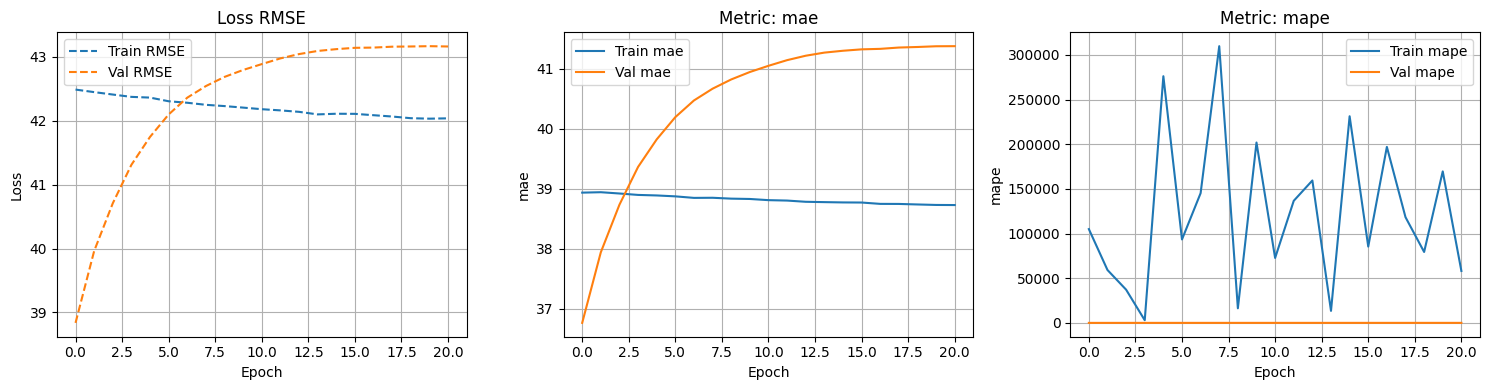

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1901.3318 - mae: 41.2649 - mape: 90.5023
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1343.5409 - mae: 33.3800 - mape: 1372.2350

Final Training Metrics:
RMSE: 38.1262
['mae', 'mape']: [34.252197265625, 8907.255859375]

Final Validation Metrics:
RMSE: 38.8364
['mae', 'mape']: [36.76423263549805, 91.2919921875]
Fitting fold 4 of 5
Training period: 2015-01-05 00:00:00+01:00 to 2020-05-21 23:00:00+02:00
Validation period: 2020-06-09 00:00:00+02:00 to 2021-11-10 23:00:00+01:00
Epoch 1/1000
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 1663.0275 - mae: 37.4973 - mape: 257079.3594 - val_loss: 8229.3926 - val_mae: 75.3181 - val_mape: 158222.9375 - learning_rate: 1.5625e-05
Epoch 2/1000
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 1819.4681 - mae: 39.2110 - mape: 215906.9844 - val_loss: 8362.8906 - val_mae: 76.1209 - val_mape: 254246.5312 - learning_rate: 1.5625e-05
Epoch 3/1000
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 1753.1685 - ma

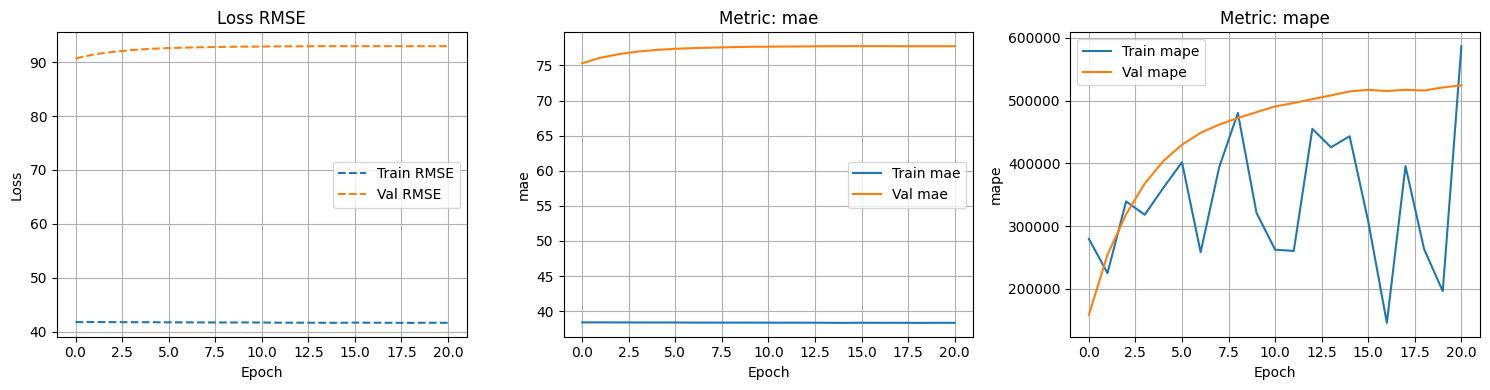

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3908.9939 - mae: 53.3953 - mape: 68658.4219
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1478.2388 - mae: 35.1895 - mape: 22636.4355

Final Training Metrics:
RMSE: 38.9662
['mae', 'mape']: [35.42828369140625, 205035.71875]

Final Validation Metrics:
RMSE: 90.7160
['mae', 'mape']: [75.31814575195312, 158222.9375]
Fitting fold 5 of 5
Training period: 2015-01-05 00:00:00+01:00 to 2021-10-27 23:00:00+02:00
Validation period: 2021-11-05 00:00:00+01:00 to 2023-05-15 23:00:00+02:00
Epoch 1/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 3195.0845 - mae: 46.8442 - mape: 94843.8203 - val_loss: 61765.8008 - val_mae: 218.4520 - val_mape: 3912810.2500 - learning_rate: 3.9063e-06
Epoch 2/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 2825.2747 - mae: 44.7520 - mape: 363184.3750 - val_loss: 61988.0586 - val_mae: 218.9509 - val_mape: 4243970.0000 - learning_rate: 3.9063e-06
Epoch 3/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 2973.14

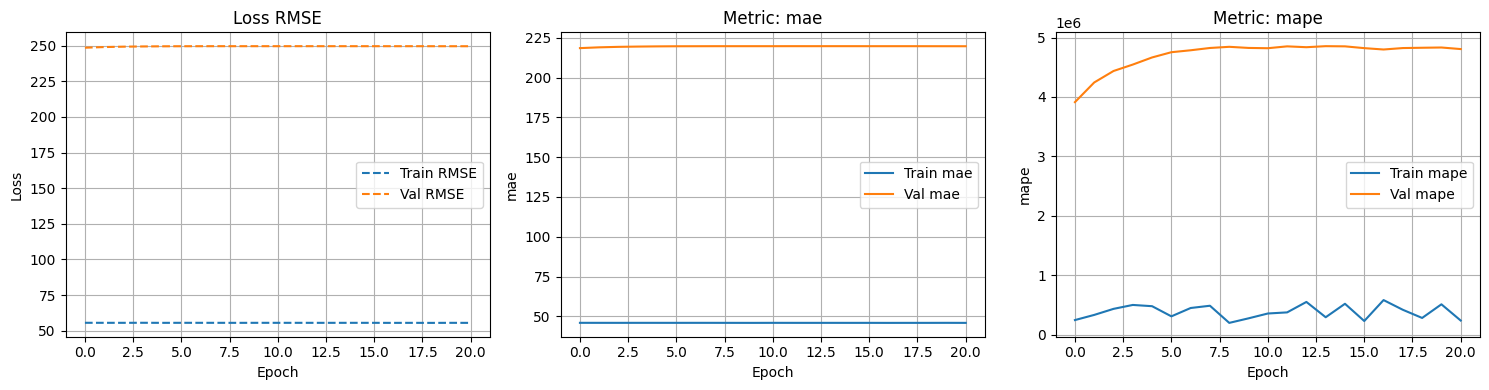

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 66946.7969 - mae: 237.3000 - mape: 2276892.7500
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1669.7113 - mae: 36.9974 - mape: 71094.3906

Final Training Metrics:
RMSE: 54.0992
['mae', 'mape']: [44.22866439819336, 254377.28125]

Final Validation Metrics:
RMSE: 248.5273
['mae', 'mape']: [218.45196533203125, 3912810.25]

Final Training Metrics:
RMSE: 40.2790
['mae', 'mape']: [34.65775604248047, 93695.1498550415]

Final Validation Metrics:
RMSE: 121.2197
['mae', 'mape']: [77.0736686706543, 814256.7598434448]


{'history_loss': [[1537.697509765625,
   1527.644775390625,
   1517.46728515625,
   1508.5111083984375,
   1502.3409423828125,
   1491.1759033203125,
   1483.0760498046875,
   1472.32666015625,
   1463.68896484375,
   1452.342529296875,
   1440.47119140625,
   1430.3609619140625,
   1419.0728759765625,
   1407.6536865234375,
   1397.5111083984375,
   1386.20263671875,
   1372.1258544921875,
   1354.6572265625,
   1349.33203125,
   1335.9224853515625,
   1326.7017822265625,
   1320.316650390625,
   1313.793701171875,
   1304.9339599609375,
   1296.4564208984375,
   1292.0106201171875,
   1283.04296875,
   1280.6649169921875,
   1273.18603515625,
   1267.0301513671875],
  [1724.6583251953125,
   1713.3900146484375,
   1704.1131591796875,
   1696.3612060546875,
   1691.436767578125,
   1679.97119140625,
   1675.7991943359375,
   1666.059814453125,
   1662.4281005859375,
   1655.0263671875,
   1643.239990234375,
   1639.347900390625,
   1638.554931640625,
   1633.6820068359375,
   1631.189

In [5]:
lstm_model.fit_rolling_horizon()


In [6]:
from scripts.config import LOGS_PATH
%tensorboard --logdir {LOGS_PATH}/LSTM/fit

In [7]:
test_results = lstm_model.model.evaluate(
            [X_past_test, X_future_test],
            y_test
        )

test_loss = np.sqrt(test_results[0])
test_metrics = test_results[1:]

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Metrics: {test_metrics}")

NameError: name 'X_past_test' is not defined

In [ ]:
from scripts.model_att import AttentionModel
model_name = "20250820-135126"

att_model = AttentionModel.from_saved_model(model_name)

att_model

In [ ]:
pred = att_model.predict(X_past_test_transformed, X_future_test_transformed)

att_model.plot_hourly_averages(y_test, pred)

In [ ]:
pred = att_model.predict(X_past_train_transformed, X_future_train_transformed)

att_model.plot_hourly_averages(y_train, pred)